In [1]:
import json, requests
from requests.auth import HTTPBasicAuth
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
res_pollenstation = requests.get(
    'http://localhost:9090/esq/indexname/pollenstation'
)

if res_pollenstation.status_code == 200:
    pollenstation_data = res_pollenstation.json()['hits']
    
pollenstation_df = pd.DataFrame([item['_source'] for item in pollenstation_data])

In [3]:
pollenstation_df

,stationname,statename
0,brisbane,qld
1,viewbank,vic
2,campbelltown_(mount_annan),nsw


In [4]:
def get_pollen_weather_df(start_year, end_year, locations):
    df = pd.DataFrame({'stationname': locations})
    dataframes = {} 
    end_year = end_year + 1
    
    for year_1 in range(start_year, end_year): 
        for index, row in df.iterrows():
            location = row['stationname']
            location_2 = location.replace('_', '%20').upper()
            url = f"http://localhost:9090/panalysis/year/{year_1}/pollen/{location}/weather/{location_2}"      
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    data_string = response.json()
                    data = json.loads(data_string)
                    identifier = f"{year_1}-{location}"
                    if identifier not in dataframes:
                        dataframes[identifier] = pd.DataFrame()
                    temp_df = pd.json_normalize(data)
                    dataframes[identifier] = pd.concat([dataframes[identifier], temp_df], ignore_index=True)
                    print(f"Success：{identifier}")
                else:
                    print(f"Failed，status_code：{response.status_code}, URL：{url}")
            except requests.RequestException as e:
                print(f"Error，URL：{url}")
                print(e)

    for identifier, df in dataframes.items():
        print(f"Identifier: {identifier}, DataFrame shape: {df.shape}")

    for identifier in dataframes.keys():
    # identifier  "year-location"
        year, location = identifier.split('-')
        variable_name = f"{location.split('_')[0]}_{year}_df"
        globals()[variable_name] = dataframes[identifier]
        print(f"Variable '{variable_name}' has been created")
    return dataframes

In [6]:
campbelltown_pollen_weather_dataframes = get_pollen_weather_df(2019, 2019, ['campbelltown_(mount_annan)'])

Success：2019-campbelltown_(mount_annan)
Identifier: 2019-campbelltown_(mount_annan), DataFrame shape: (12, 11)
Variable 'campbelltown_2019_df' has been created


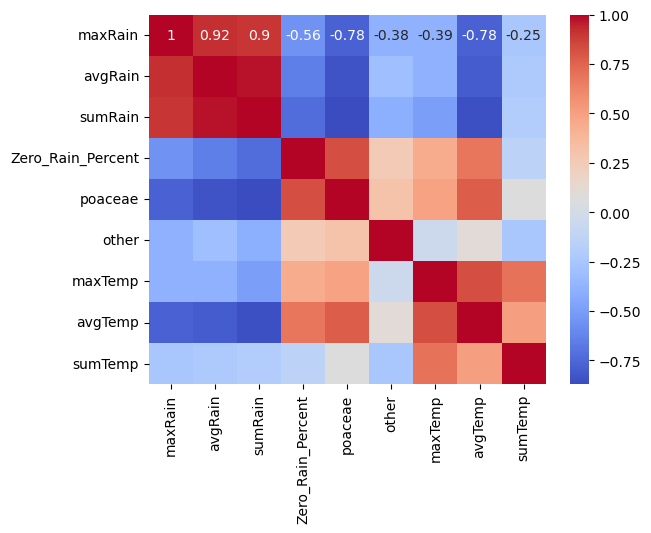

For 'poaceae' , most_positive_correlated_column: Zero_Rain_Percent (r = 0.83)
For 'poaceae' , most_negative_correlated_column: sumRain (r = -0.87)


In [8]:
df = campbelltown_2019_df.drop('date', axis=1)
df = df.drop('location', axis=1)

correlation_matrix = df.corr()
target_column = 'poaceae'
corrs = correlation_matrix[target_column].drop(target_column)

most_positive_correlated_column = corrs.idxmax()
most_negative_correlated_column = corrs.idxmin()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
print(f"For '{target_column}' , most_positive_correlated_column: {most_positive_correlated_column} (r = {corrs.max():.2f})")
print(f"For '{target_column}' , most_negative_correlated_column: {most_negative_correlated_column} (r = {corrs.min():.2f})")

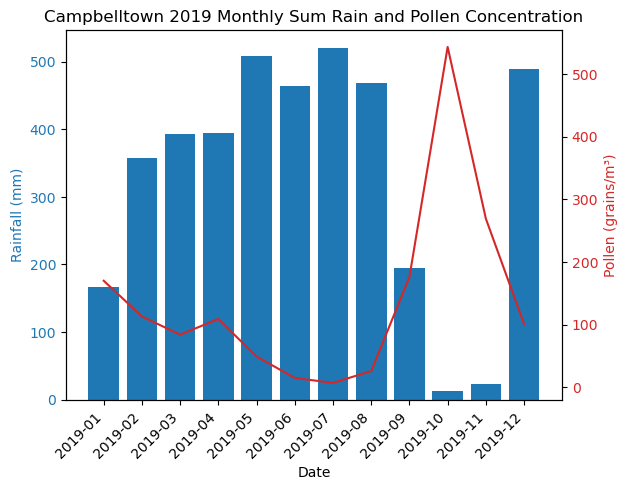

In [11]:
fig, ax1 = plt.subplots()

ax1.set_title('Campbelltown 2019 Monthly Sum Rain and Pollen Concentration')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rainfall (mm)', color='tab:blue')

color = 'tab:blue'
ax1.bar(campbelltown_2019_df['date'], campbelltown_2019_df['sumRain'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()

ax2.set_ylabel('Pollen (grains/m³)', color='tab:red')  
ax2.plot(campbelltown_2019_df['date'], campbelltown_2019_df['poaceae'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

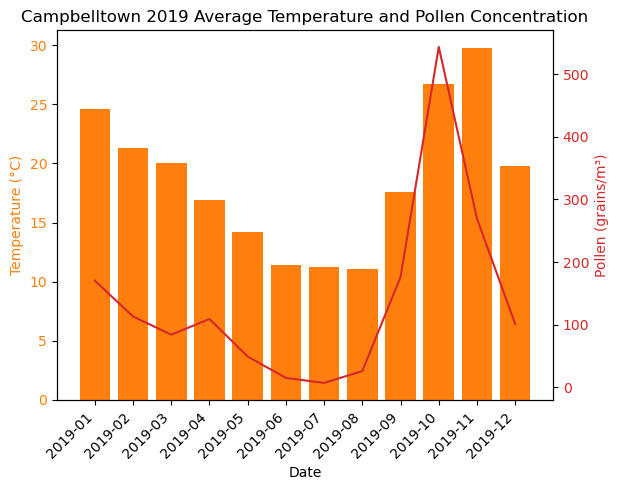

In [12]:
fig, ax1 = plt.subplots()

ax1.set_title('Campbelltown 2019 Average Temperature and Pollen Concentration')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)', color='tab:orange')

color = 'tab:orange'
ax1.bar(campbelltown_2019_df['date'], campbelltown_2019_df['avgTemp'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45, ha='right') 

ax2 = ax1.twinx()

ax2.set_ylabel('Pollen (grains/m³)', color='tab:red')  
ax2.plot(campbelltown_2019_df['date'], campbelltown_2019_df['poaceae'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

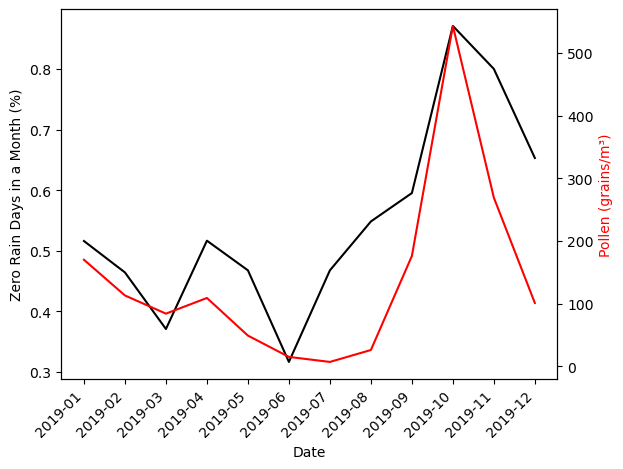

In [13]:
fig, ax1 = plt.subplots()

plt.xticks(rotation=45, ha='right') 

ax2 = ax1.twinx()
ax1.plot(campbelltown_2019_df['date'], campbelltown_2019_df['Zero_Rain_Percent'], 'black')  
ax2.plot(campbelltown_2019_df['date'], campbelltown_2019_df['poaceae'], 'r-') 

ax1.set_xlabel('Date')
ax1.set_ylabel('Zero Rain Days in a Month (%)', color='black')
ax2.set_ylabel('Pollen (grains/m³)', color='r')


plt.show()

In [14]:
pollen_weather_dataframes = get_pollen_weather_df(2016, 2019, ['brisbane','viewbank','campbelltown_(mount_annan)'])

Success：2016-brisbane
Success：2016-viewbank
Success：2016-campbelltown_(mount_annan)
Success：2017-brisbane
Success：2017-viewbank
Success：2017-campbelltown_(mount_annan)
Success：2018-brisbane
Success：2018-viewbank
Success：2018-campbelltown_(mount_annan)
Success：2019-brisbane
Success：2019-viewbank
Success：2019-campbelltown_(mount_annan)
Identifier: 2016-brisbane, DataFrame shape: (3, 11)
Identifier: 2016-viewbank, DataFrame shape: (4, 11)
Identifier: 2016-campbelltown_(mount_annan), DataFrame shape: (6, 11)
Identifier: 2017-brisbane, DataFrame shape: (10, 11)
Identifier: 2017-viewbank, DataFrame shape: (5, 11)
Identifier: 2017-campbelltown_(mount_annan), DataFrame shape: (12, 11)
Identifier: 2018-brisbane, DataFrame shape: (12, 11)
Identifier: 2018-viewbank, DataFrame shape: (4, 11)
Identifier: 2018-campbelltown_(mount_annan), DataFrame shape: (12, 11)
Identifier: 2019-brisbane, DataFrame shape: (12, 11)
Identifier: 2019-viewbank, DataFrame shape: (5, 11)
Identifier: 2019-campbelltown_(mo

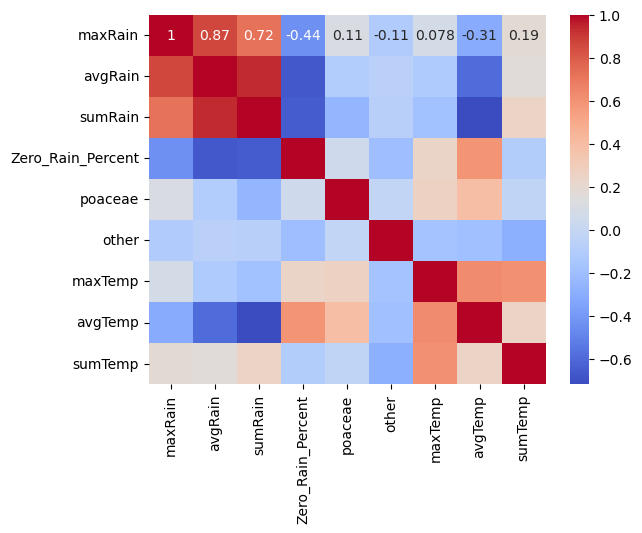

For 'poaceae' , most_positive_correlated_column: avgTemp (r = 0.40)
For 'poaceae' , most_negative_correlated_column: sumRain (r = -0.25)


In [15]:
concatenated_df = pd.concat(pollen_weather_dataframes.values())
ddf = concatenated_df.drop('date', axis=1)
ddf = ddf.drop('location', axis=1)

correlation_matrix = ddf.corr()
target_column = 'poaceae'
corrs = correlation_matrix[target_column].drop(target_column)

most_positive_correlated_column = corrs.idxmax()
most_negative_correlated_column = corrs.idxmin()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
print(f"For '{target_column}' , most_positive_correlated_column: {most_positive_correlated_column} (r = {corrs.max():.2f})")
print(f"For '{target_column}' , most_negative_correlated_column: {most_negative_correlated_column} (r = {corrs.min():.2f})")

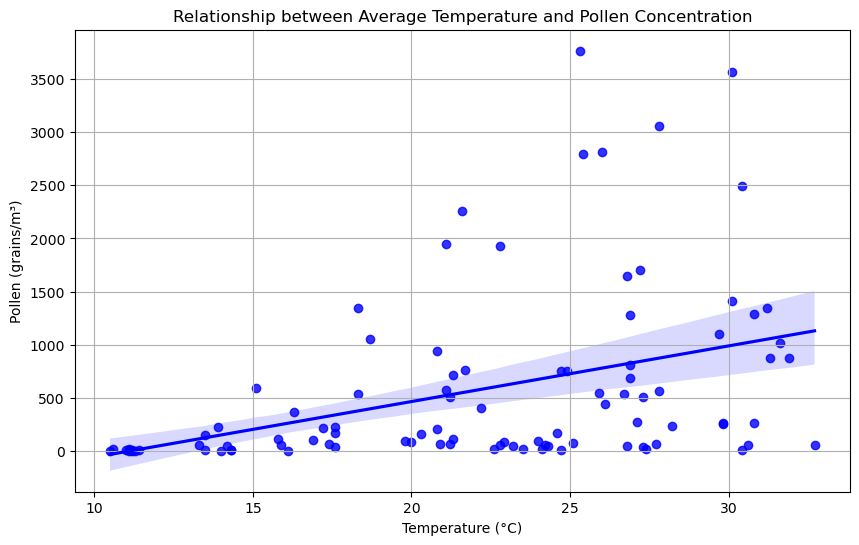

In [18]:
plt.figure(figsize=(10, 6))
sns.regplot(x = concatenated_df['avgTemp'], y = concatenated_df['poaceae'], scatter=True, color='blue')
plt.title('Relationship between Average Temperature and Pollen Concentration')
plt.xlabel('Temperature (°C)')
plt.ylabel('Pollen (grains/m³)')
plt.grid(True)
plt.show()

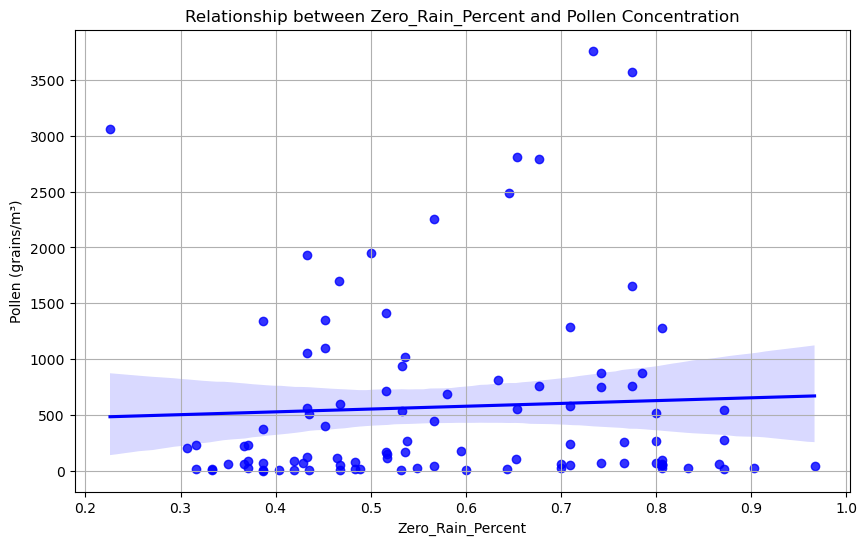

In [17]:
plt.figure(figsize=(10, 6))
sns.regplot(x = concatenated_df['Zero_Rain_Percent'], y = concatenated_df['poaceae'], scatter=True, color='blue')
plt.title('Relationship between Zero_Rain_Percent and Pollen Concentration')
plt.xlabel('Zero_Rain_Percent')
plt.ylabel('Pollen (grains/m³)')
plt.grid(True)
plt.show()

In [ ]:
#filtered_df = concatenated_df[concatenated_df['poaceae'] < 500]
#filtered_df